# Exercício Cap. 10 - transmitância de gases na atmosfera e da água pura - absorção.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from pfser_atividades import sum_radiation, atmospheric_state_variables, transmitance, plots

In [ ]:
# Graph style

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

## Sum radiance

In [2]:
# Parameters

latitude = -22.60877
date = '2022-01-17'
time = '14:10'

sum_constant_wavelength = {
    '460nm': 2099.99,
    '540nm': 1857.50,
    '650nm': 1597.50,
    '760nm': 1222.50,
    '800nm': 1144.70,
}

In [3]:
julian_day = sum_radiation.get_julian_day(date)
day_angle = sum_radiation.compute_day_angle(date)
sum_hour = sum_radiation.compute_sum_hour(time)
sum_declination = sum_radiation.compute_sum_declination(day_angle)
corr_factor = sum_radiation.compute_excentric_corr_factor(day_angle)
zenith_angle, cos_zenith_angle = sum_radiation.compute_zenith_angle(sum_declination, sum_hour, latitude)

In [4]:
# Computing irradiance and radiance for each wavelengh

irradiance_parameters = {
    'correction_factor': corr_factor,
    'sum_declination': sum_declination,
    'sum_hour': sum_hour, 
    'latitude': latitude,
}

irradiance = {wavelength: sum_radiation.compute_irradiance(sum_constant=sum_constant, **irradiance_parameters) 
              for wavelength, sum_constant in sum_constant_wavelength.items()}
radiance = {wavelength: sum_radiation.compute_radiance(irradiance_) for wavelength, irradiance_ in irradiance.items()}

#### Optical paths

In [5]:
max_altitude = 3000000 # altitude in cm (since our coefficients are in this scale)
max_depth = 200 # depth in meters

In [6]:
altitude = np.linspace(0, max_altitude, num=100)
depth = np.linspace(0, max_depth, num=100)

In [7]:
optical_path_atmosphere = transmitance.optical_path(altitude, cos_zenith_angle)
optical_path_water = transmitance.optical_path(depth, cos_zenith_angle)

## Computing absorbtion coefficients

### Atmosphere

#### Computing gas molecule density

In [8]:
gases_density = atmospheric_state_variables.compute_gases_density()

#### Gases cross-sections

In [9]:
# Obs: cross_sections (cm²/molecule)

cross_sections_oxigen = {
    '460nm': 8.37e-27,
    '540nm': 4.27e-27,
    '650nm': 2.17e-27,
    '760nm': 2.79e-24, # https://uvvis.mpch-mainz.gwdg.de/uvvis/cross_sections/Oxygen/O2_Bogumil(2003)_293K_650-799.6nm.txt
    '800nm': 1.55e-27, # https://uvvis.mpch-mainz.gwdg.de/uvvis/cross_sections/Oxygen/O2_Bogumil(2003)_293K_650-799.6nm.txt
}

cross_sections_methane = {
    '460nm': 1.60e-27,
    '540nm': 2.67e-26,
    '650nm': 1.41e-26,
    '760nm': 1.89e-26, # https://uvvis.mpch-mainz.gwdg.de/uvvis_data/cross_sections/Alkanes+alkyl%20radicals/Alkanes/CH4_Giver(1978)_293K_694.5-860.5nm.txt
    '800nm': 3.35e-25,
}

#### Coefficients

In [10]:
absorption_coefficient_oxigen = transmitance.compute_coefficients(cross_sections_oxigen, gases_density['oxigen'])
absorption_coefficient_methane = transmitance.compute_coefficients(cross_sections_methane, gases_density['methane'])

absorption_coefficient_air = transmitance.aggregate_coefficients(
    [absorption_coefficient_oxigen, absorption_coefficient_methane]
)

#### Transmitance

In [11]:
transmitance_absorption_oxigen = transmitance.compute_transmitance(optical_path_atmosphere, absorption_coefficient_oxigen)
transmitance_absorption_methane = transmitance.compute_transmitance(optical_path_atmosphere, absorption_coefficient_methane)
transmitance_absorption_air = transmitance.compute_transmitance(optical_path_atmosphere, absorption_coefficient_air)

#### Attenuation

In [12]:
attenuation_absorption_oxigen = transmitance.compute_attenuation(irradiance, transmitance_absorption_oxigen)
attenuation_absorption_methane = transmitance.compute_attenuation(irradiance, transmitance_absorption_methane)
attenuation_absorption_air = transmitance.compute_attenuation(irradiance, transmitance_absorption_air)

#### Plots

array([<AxesSubplot:xlabel='transmitance', ylabel='altitude (m)'>,
       <AxesSubplot:xlabel='irradiance (W/m².nm)', ylabel='altitude (m)'>],
      dtype=object)

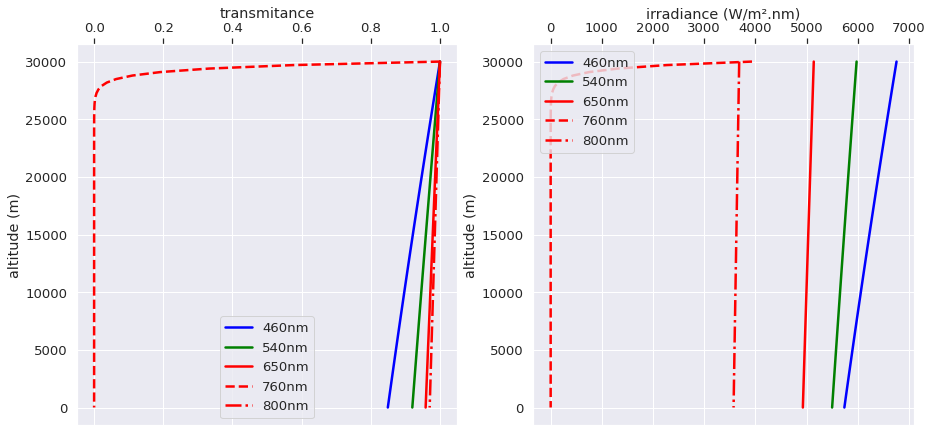

In [15]:
plots.plot_transmitance(transmitance=transmitance_absorption_oxigen,
                        attenuation=attenuation_absorption_oxigen,
                        altitude=altitude,);

### Water

In [16]:
# Updated irradiance_values

updated_irradiance = {key:value[-1] for key, value in attenuation_absorption_air.items()}

In [17]:
absorption_coefficient_water= {
    '460nm': 0.00979, # Pope e Fry (1997)
    '540nm': 0.0474, # Pope e Fry (1997)
    '650nm': 0.340, # Pope e Fry (1997)
    '760nm': 2.55, # Smith e Baker(1981
    '800nm': 2.07, # Smith e Baker(1981
}

#### Transmitance

In [18]:
transmitance_absorption_water = transmitance.compute_transmitance(optical_path_water, absorption_coefficient_water)

#### Attenuation

In [19]:
attenuation_absorption_water = transmitance.compute_attenuation(updated_irradiance, transmitance_absorption_water)

array([<AxesSubplot:xlabel='transmitance', ylabel='depth (m)'>,
       <AxesSubplot:xlabel='irradiance (W/m².nm)', ylabel='depth (m)'>],
      dtype=object)

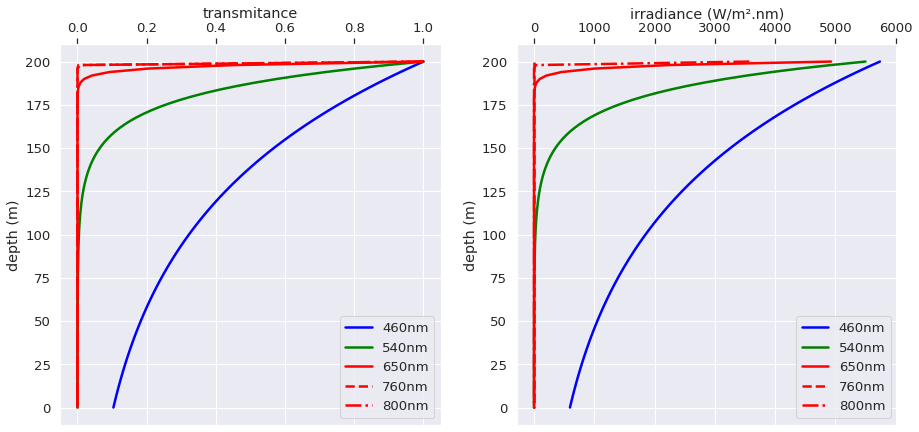

In [20]:
plots.plot_transmitance(transmitance=transmitance_absorption_water,
                        attenuation=attenuation_absorption_water,
                        altitude=depth,
                        water=True);